### AULA

In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification

# Simulação dos dados
import numpy as np
import pandas as pd

np.random.seed(42)  # Para reprodutibilidade

# Número de registros
n = 500

# Variáveis numéricas
idade = np.random.randint(18, 70, n)
tempo_uso = np.random.exponential(scale=24, size=n).clip(1, 120).round(1)  # em meses
interacoes = np.random.poisson(lam=tempo_uso / 5).clip(0, None)
satisfacao = np.random.randint(1, 5 + 1, n)  # escala 1 a 5
reclamacoes = np.random.poisson(lam=(6 - satisfacao) / 2).clip(0, None)
gasto_mensal = np.random.normal(300, 120, n).clip(20, 1500).round(2)

# Variáveis categóricas
genero = np.random.choice(['Feminino', 'Masculino', 'Não-binário', 'Prefiro não informar'],
                          n, p=[0.48, 0.48, 0.02, 0.02])

raca = np.random.choice([
    'Branca', 'Preta', 'Parda', 'Amarela', 'Indígena', 'Prefiro não informar'
], n, p=[0.42, 0.10, 0.45, 0.01, 0.01, 0.01])

area_formacao = np.random.choice([
    'Humanas', 'Exatas', 'Biológicas', 'Negócios', 'Tecnologia', 'Artes'
], n)

# Construindo o DataFrame
df = pd.DataFrame({
    'idade': idade,
    'tempo_uso': tempo_uso,
    'interacoes': interacoes,
    'satisfacao': satisfacao,
    'reclamacoes': reclamacoes,
    'gasto_mensal': gasto_mensal,
    'genero': genero,
    'raca': raca,
    'area_formacao': area_formacao
})

# ----- CRIAÇÃO DA VARIÁVEL ALVO (CHURN) -----
# Calcula score de cancelamento
score_churn = (
    (5 - df['satisfacao']) * 0.4 +
    (df['reclamacoes']) * 0.3 +
    (1 / (df['interacoes'] + 1)) * 0.2 +
    (1 / (df['tempo_uso'] + 1)) * 0.1
)

# Normaliza score para (0,1)
score_churn = (score_churn - score_churn.min()) / (score_churn.max() - score_churn.min())

# Probabilidade aumenta conforme o score
df['churn'] = np.random.binomial(1, score_churn)

df.head()



,idade,tempo_uso,interacoes,satisfacao,reclamacoes,gasto_mensal,genero,raca,area_formacao,churn
0,56,74.4,15,5,0,336.73,Masculino,Branca,Tecnologia,0
1,69,32.1,6,4,0,394.12,Feminino,Branca,Exatas,0
2,46,19.4,4,1,2,536.22,Masculino,Branca,Biológicas,1
3,32,22.7,2,5,1,245.76,Feminino,Parda,Negócios,0
4,60,13.1,3,2,3,436.65,Feminino,Parda,Humanas,1


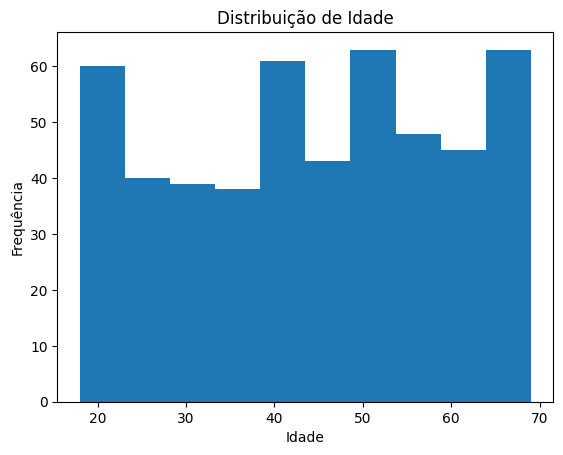

In [3]:
import matplotlib.pyplot as plt

plt.hist(df['idade'])
plt.xlabel('Idade')
plt.ylabel('Frequência')
plt.title('Distribuição de Idade')
plt.show()


In [4]:
df.groupby('churn')['satisfacao'].mean()


,satisfacao
churn,
0,3.469453
1,2.079365


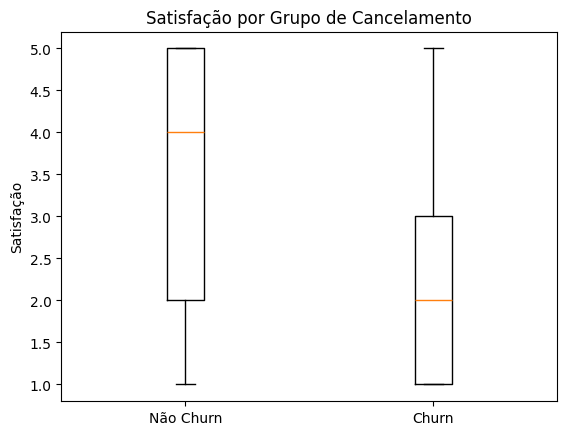

In [5]:
plt.boxplot([df[df.churn==0]['satisfacao'], df[df.churn==1]['satisfacao']])
plt.xticks([1,2], ['Não Churn', 'Churn'])
plt.ylabel('Satisfação')
plt.title('Satisfação por Grupo de Cancelamento')
plt.show()

In [6]:
# qual a media de pessoas que saem por raca
df.groupby('raca')['churn'].mean().sort_values()

,churn
raca,
Parda,0.351598
Branca,0.384259
Amarela,0.400000
Preta,0.416667
Indígena,0.500000
Prefiro não informar,0.750000


In [7]:
df.groupby('genero')['churn'].mean().sort_values()


,churn
genero,
Prefiro não informar,0.250000
Feminino,0.364706
Masculino,0.397380
Não-binário,0.500000


In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# -------------------
# 1. Selecionando features e alvo
# -------------------
X = df.drop('churn', axis=1)
y = df['churn']

# -------------------
# 2. Identificando tipos de variáveis
# -------------------
numeric_features = ['idade', 'tempo_uso', 'interacoes', 'satisfacao', 'reclamacoes', 'gasto_mensal']
categorical_features = ['genero', 'raca', 'area_formacao']

# -------------------
# 3. Pré-processamento
# -------------------
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)



# Ajustar e transformar X
X_prepared = preprocessor.fit_transform(X)

feature_names = preprocessor.get_feature_names_out()
print(feature_names)

# -------------------
# 4. Divisão treino / teste
# -------------------
X_train, X_test, y_train, y_test = train_test_split(X_prepared, y, test_size=0.2, random_state=42)

print("Formato de X após transformação:", X_prepared.shape)
print("Formato de X_train:", X_train.shape)
print("Formato de y_train:", y_train.shape)

pd.DataFrame(X_train)

['num__idade' 'num__tempo_uso' 'num__interacoes' 'num__satisfacao'
 'num__reclamacoes' 'num__gasto_mensal' 'cat__genero_Masculino'
 'cat__genero_Não-binário' 'cat__genero_Prefiro não informar'
 'cat__raca_Branca' 'cat__raca_Indígena' 'cat__raca_Parda'
 'cat__raca_Prefiro não informar' 'cat__raca_Preta'
 'cat__area_formacao_Biológicas' 'cat__area_formacao_Exatas'
 'cat__area_formacao_Humanas' 'cat__area_formacao_Negócios'
 'cat__area_formacao_Tecnologia']
Formato de X após transformação: (500, 19)
Formato de X_train: (400, 19)
Formato de y_train: (400,)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,1.649686,-0.038450,0.029003,0.742840,-0.350058,0.151786,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.745552,-0.251831,-0.705257,1.446287,-1.025845,0.030081,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.214366,-0.444293,-0.705257,1.446287,-1.025845,-0.690708,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.147793,-0.113761,-0.154562,0.742840,-1.025845,0.114004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.917380,-0.682777,-0.154562,-1.367501,1.677304,-2.263687,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,-1.745552,-0.862687,-0.705257,0.039393,1.677304,-0.955853,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
396,-1.346112,1.262755,0.763263,1.446287,-1.025845,-0.754904,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
397,1.583113,-0.933814,-0.705257,1.446287,-1.025845,0.608935,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
398,1.250246,0.543117,0.212568,-0.664054,-0.350058,1.070514,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


model = LogisticRegression()
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print(scores)
print("Acurácia média (validação cruzada):", scores.mean())


[0.7625 0.6875 0.75   0.7625 0.725 ]
Acurácia média (validação cruzada): 0.7375


In [10]:
# Treina o modelo final usando todo o conjunto de treino
model.fit(X_train, y_train)

# Avaliação no conjunto de teste
y_pred = model.predict(X_test)

print("Acurácia no conjunto de teste:", accuracy_score(y_test, y_pred))
print("\nMatriz de Confusão:\n", confusion_matrix(y_test, y_pred))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))

Acurácia no conjunto de teste: 0.75

Matriz de Confusão:
 [[50  9]
 [16 25]]

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.76      0.85      0.80        59
           1       0.74      0.61      0.67        41

    accuracy                           0.75       100
   macro avg       0.75      0.73      0.73       100
weighted avg       0.75      0.75      0.75       100



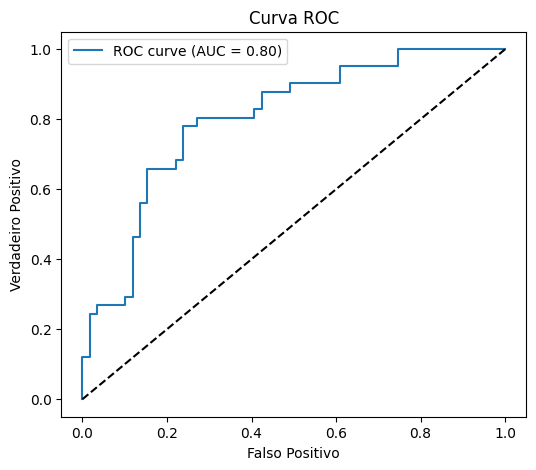

              precision    recall  f1-score   support

           0       0.76      0.85      0.80        59
           1       0.74      0.61      0.67        41

    accuracy                           0.75       100
   macro avg       0.75      0.73      0.73       100
weighted avg       0.75      0.75      0.75       100



In [11]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt


model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadeiro Positivo')
plt.title('Curva ROC')
plt.legend()
plt.show()

print(classification_report(y_test, y_pred))


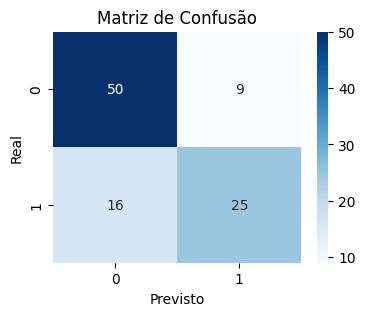

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

### CASA

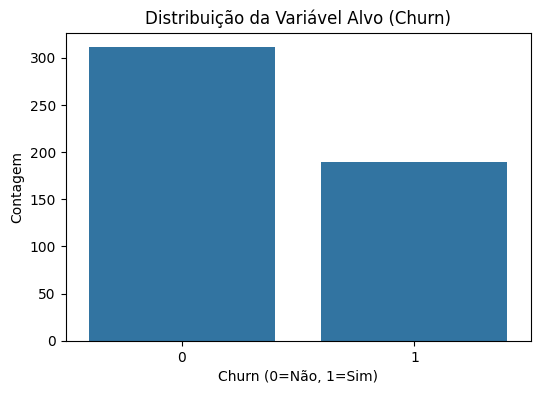

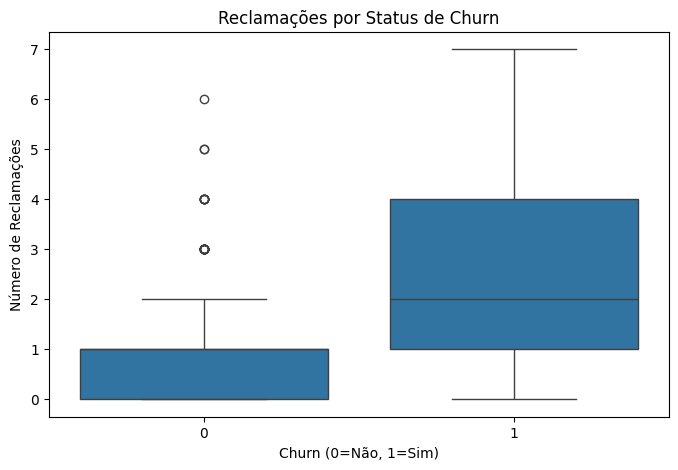

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- TAREFA 1: Gráficos Adicionais de Data Understanding ---

# 1. Distribuição da Variável Alvo (Churn)
# Verificar o balanceamento da classe.
plt.figure(figsize=(6, 4))
sns.countplot(x='churn', data=df)
plt.title('Distribuição da Variável Alvo (Churn)')
plt.xlabel('Churn (0=Não, 1=Sim)')
plt.ylabel('Contagem')
plt.show()

# 2. Distribuição de Reclamações por Churn
# Observar se o número de reclamações está relacionado ao cancelamento.
plt.figure(figsize=(8, 5))
sns.boxplot(x='churn', y='reclamacoes', data=df)
plt.title('Reclamações por Status de Churn')
plt.xlabel('Churn (0=Não, 1=Sim)')
plt.ylabel('Número de Reclamações')
plt.show()

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline # Import Pipeline

# --- TAREFA 2: Testar outros modelos ---

# Criar um pipeline para o RandomForestClassifier
# O pré-processamento já foi aplicado a X_train e X_test na célula anterior
rf_pipeline = Pipeline(steps=[
    ('modelo', RandomForestClassifier(random_state=42))
])

# Validação Cruzada (Cross-Validation) usando o pipeline
# Usando F1-score como métrica, mais robusto para classes desbalanceadas
rf_scores = cross_val_score(rf_pipeline, X_train, y_train, cv=5, scoring='f1')
print(f"Scores F1 da Validação Cruzada (Random Forest): {rf_scores}")
print(f"F1-score Média (Validação Cruzada): {rf_scores.mean():.4f}")

# Treinar o modelo final (o pipeline) e avaliar no conjunto de teste
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

print("\nRelatório de Classificação (Random Forest no Teste):")
print(classification_report(y_test, y_pred_rf))

Scores F1 da Validação Cruzada (Random Forest): [0.70967742 0.29268293 0.6984127  0.66666667 0.48979592]
F1-score Média (Validação Cruzada): 0.5714

Relatório de Classificação (Random Forest no Teste):
              precision    recall  f1-score   support

           0       0.78      0.86      0.82        59
           1       0.77      0.66      0.71        41

    accuracy                           0.78       100
   macro avg       0.78      0.76      0.77       100
weighted avg       0.78      0.78      0.78       100



In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline # Importar Pipeline

# --- TAREFA 3: Otimização de Hiperparâmetros com GridSearchCV ---


pipeline_logreg = Pipeline(steps=[
    ('modelo', LogisticRegression(solver='liblinear', random_state=42, max_iter=1000))
])

# Definir o grid de parâmetros para a Regressão Logística dentro do pipeline
param_grid = {
    'modelo__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Força de regularização (inversa)
    'modelo__penalty': ['l2']
}

# Configurar o Grid Search com o pipeline
grid_search = GridSearchCV(
    pipeline_logreg,
    param_grid,
    cv=5, # 5-fold cross-validation
    scoring='f1', # Otimizar pelo F1-score
    n_jobs=-1 # Usar todos os núcleos da CPU
)

# Executar a busca no conjunto de treino
grid_search.fit(X_train, y_train)

# Mostrar os melhores resultados
print(f"Melhor F1-score na validação: {grid_search.best_score_:.4f}")
print(f"Melhores Hiperparâmetros: {grid_search.best_params_}")

# Avaliar o modelo otimizado no conjunto de teste
best_logreg_model = grid_search.best_estimator_
y_pred_tuned = best_logreg_model.predict(X_test)

print("\nRelatório de Classificação do Modelo Otimizado:")
print(classification_report(y_test, y_pred_tuned))

Melhor F1-score na validação: 0.6359
Melhores Hiperparâmetros: {'modelo__C': 0.01, 'modelo__penalty': 'l2'}

Relatório de Classificação do Modelo Otimizado:
              precision    recall  f1-score   support

           0       0.77      0.85      0.81        59
           1       0.74      0.63      0.68        41

    accuracy                           0.76       100
   macro avg       0.76      0.74      0.75       100
weighted avg       0.76      0.76      0.76       100



Threshold que maximiza o F1-score: 0.3759
Máximo F1-score alcançado: 0.7500

Relatório de Classificação com Threshold Otimizado (Max F1):
              precision    recall  f1-score   support

           0       0.89      0.68      0.77        59
           1       0.65      0.88      0.75        41

    accuracy                           0.76       100
   macro avg       0.77      0.78      0.76       100
weighted avg       0.79      0.76      0.76       100



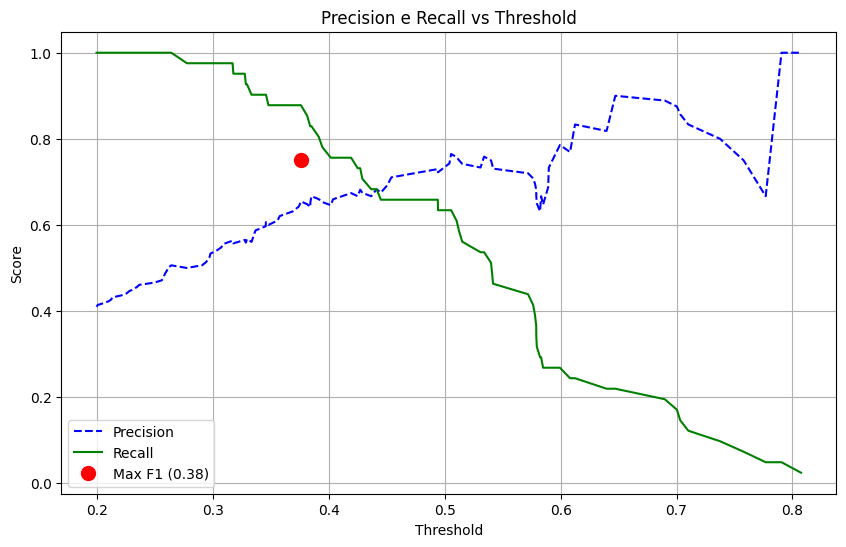

In [16]:
from sklearn.metrics import precision_recall_curve, f1_score
import numpy as np
import matplotlib.pyplot as plt

# O modelo 'model' (LogisticRegression) já deve estar treinado das células anteriores.

# --- TAREFA 4: Análise e Otimização do Threshold de Classificação ---

# 1. Obter as probabilidades de previsão para a classe '1' (Churn)
y_probs = best_logreg_model.predict_proba(X_test)[:, 1]

# 2. Calcular Precision, Recall e Thresholds
# A função 'precision_recall_curve' é ideal para isso
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

# 3. Encontrar o Threshold que maximiza o F1-score
# O último valor de 'thresholds' é omitido, então o último f1_score é NaN e precisa ser tratado
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
f1_scores = np.nan_to_num(f1_scores)

optimal_idx = np.argmax(f1_scores)
# O threshold tem um item a menos, então pegamos o índice correspondente
optimal_threshold = thresholds[optimal_idx]
optimal_f1 = f1_scores[optimal_idx]

print(f"Threshold que maximiza o F1-score: {optimal_threshold:.4f}")
print(f"Máximo F1-score alcançado: {optimal_f1:.4f}")

# 4. Avaliar o modelo com o novo threshold otimizado
y_pred_opt_th = (y_probs >= optimal_threshold).astype(int)

print("\nRelatório de Classificação com Threshold Otimizado (Max F1):")
print(classification_report(y_test, y_pred_opt_th))

# Visualização da Curva Precision-Recall vs Threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.plot(optimal_threshold, optimal_f1, "ro", markersize=10, label=f"Max F1 ({optimal_threshold:.2f})")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision e Recall vs Threshold")
plt.legend()
plt.grid(True)
plt.show()